In [1]:
import os 
import random
import shutil
from shutil import copyfile

In [2]:
import numpy as np
import pandas as pd 
import random
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

In [4]:
import tensorflow as tf 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from tensorflow.keras import Model
import matplotlib.pyplot as plt 
from matplotlib.offsetbox import (TextArea,DrawingArea,OffsetImage,AnnotationBbox)
import matplotlib.patches as mpatches
from sklearn.utils import shuffle
from tqdm import tqdm 

In [5]:
base_dir = 'C:/Users/SEISANG-G06/Documents/LINN/DATA_CLEANING/BT'
os.chdir(base_dir)

In [6]:
df = pd.read_csv("Brain Tumor.csv")[["Image","Class","Mean"]]
display(df.head())
print(df.shape)

,Image,Class,Mean
0,Image1,0,6.535339
1,Image2,0,8.749969
2,Image3,1,7.341095
3,Image4,1,5.958145
4,Image5,0,7.315231


(3762, 3)


In [7]:
df.isna().sum()

Image    0
Class    0
Mean     0
dtype: int64

In [8]:
df['Class'].value_counts()

0    2079
1    1683
Name: Class, dtype: int64

# Data Splitting

In [9]:
df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=11)
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=11)

In [10]:
df_test.shape

(753, 3)

In [11]:
df_val.shape

(753, 3)

In [12]:
train_labels = df_train['Class'].values
train_file_names = df_train['Image'].values

In [13]:
val_labels = df_val['Class'].values
val_file_names = df_val['Image'].values

In [14]:
test_labels = df_test['Class'].values
test_file_names = df_test['Image'].values

In [15]:
def split_array_labels(arr_image,arr_label):
    arr_image_0 = arr_image[np.where(arr_label==0)]
    arr_image_1 = arr_image[np.where(arr_label==1)]
    return {'0':arr_image_0,'1':arr_image_1}

In [16]:
train_arr_dict = split_array_labels(train_file_names,train_labels)
val_arr_dict = split_array_labels(val_file_names,val_labels)
test_arr_dict = split_array_labels(test_file_names,test_labels)

In [17]:
def create_empty_space(base_dir):
    check_exist_path = os.path.join(base_dir,'_MODELLING')
    
    if os.path.isdir(check_exist_path):
        shutil.rmtree(check_exist_path)
        print("Remove old directories")
        
    for label in ['0','1']:
        train_dir = os.path.join(base_dir,'_MODELLING','training',label)
        val_dir = os.path.join(base_dir,'_MODELLING','validation',label)
        test_dir = os.path.join(base_dir,'_MODELLING','testing',label)
        
        
        os.makedirs(train_dir)
        os.makedirs(val_dir)
        os.makedirs(test_dir)
    print(f"Create empty training,validation and testing directories")
create_empty_space(base_dir)

Remove old directories
Create empty training,validation and testing directories


In [18]:
def split_data(source_dir,train_arr_dict,val_arr_dict,test_arr_dict):
    for label in tqdm(['0','1']):
        for filename in train_arr_dict[label]:
            file_name=f"{filename}.jpg"
            source = os.path.join(source_dir,'Brain Tumor','Brain Tumor',file_name)
            destination = os.path.join(base_dir,'_MODELLING','training',label,file_name)
            copyfile(source,destination)
            
        for filename in val_arr_dict[label]:
            file_name = f"{filename}.jpg"
            source = os.path.join(source_dir,'Brain Tumor','Brain Tumor',file_name)
            destination = os.path.join(base_dir,'_MODELLING','validation',label,file_name)
            copyfile(source,destination)
            
        for filename in test_arr_dict[label]:
            file_name = f"{filename}.jpg"
            source = os.path.join(source_dir,'Brain Tumor','Brain Tumor',file_name)
            destination = os.path.join(base_dir,'_MODELLING','testing',label,file_name)
            copyfile(source,destination)
        print(f"Created training,validation and testing directories containing images")

split_data(base_dir,train_arr_dict,val_arr_dict,test_arr_dict)
            

 50%|█████     | 1/2 [00:05<00:05,  5.05s/it]

Created training,validation and testing directories containing images


100%|██████████| 2/2 [00:09<00:00,  4.60s/it]

Created training,validation and testing directories containing images


In [19]:
model_dir = 'C:/Users/SEISANG-G06/Documents/LINN/DATA_CLEANING/BT/_MODELLING'
os.chdir(model_dir)

mytrain_test_val_list= []
mylabel_list = []
myitem_list = []
vis_images = []
vis_labels= [ ]

train_test_val = tf.io.gfile.listdir(model_dir)
for folder in train_test_val:
    path1 = os.path.join(model_dir,folder)
    label_list = tf.io.gfile.listdir(path1)
    for label in label_list:
        file_path = os.path.join(path1,label)
        item = os.listdir(file_path)
        
        
        mytrain_test_val_list.append(folder)
        mylabel_list.append(label)
        myitem_list.append(len(item))
        
        my_files = item[0:5]
        for file in my_files:
            vis_image = os.path.join(file_path,file)
            vis_labels.append(label)
            vis_images.append(vis_image)
pd.DataFrame({"Train Test":mytrain_test_val_list,"Labels":mylabel_list,'Number of Items':myitem_list})

,Train Test,Labels,Number of Items
0,testing,0,404
1,testing,1,349
2,training,0,1257
3,training,1,999
4,validation,0,418
5,validation,1,335


# Data Augmentation

In [20]:
def train_val_generators(TRAINING_DIR,VALDATION_DIR,TEST_DIR):
    train_datagen = ImageDataGenerator(rescale=1./127.5,
                                       rotation_range=30,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')
    
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,batch_size=32,class_mode='binary',target_size=(150,150))
    
    valid_or_test_datagen = ImageDataGenerator(rescale=1./127.5)
    validation_generator = valid_or_test_datagen.flow_from_directory(directory=VALDATION_DIR,batch_size=32,class_mode='binary',
                                                                     target_size=(150,150))
    
    test_generator = valid_or_test_datagen.flow_from_directory(directory=TEST_DIR,batch_size=32,class_mode='binary',
                                                               target_size=(150,150))
    
    return train_generator,validation_generator,test_generator

In [21]:
training_dir = os.path.join(model_dir,'training')
validation_dir = os.path.join(model_dir,'validation')
testing_dir = os.path.join(model_dir,'testing')

print(testing_dir)

C:/Users/SEISANG-G06/Documents/LINN/DATA_CLEANING/BT/_MODELLING\testing


In [22]:
train_generator,validation_generator,test_generator = train_val_generators(training_dir,validation_dir,testing_dir)

Found 2256 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


# ImageNet

In [23]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(150,150,3),
                                               include_top=False,weights='imagenet')

base_model.trainable = False
last_output = base_model.output
num_trainable_params = sum([w.shape.num_elements()for w in base_model.trainable_weights])

print(f"There are {num_trainable_params:,} trainable parameters in this model.")
print(f"The pretrained model has type: {type(base_model)}")



There are 0 trainable parameters in this model.
The pretrained model has type: <class 'keras.src.engine.functional.Functional'>


# Transfer Learning

In [56]:
def transfer_learning(last_output,pre_trained_model,size_inner=1024,droprate=0.6):
    x=tf.keras.layers.Flatten()(last_output)
    x=tf.keras.layers.Dense(size_inner,activation='relu')(x)
    x=tf.keras.layers.Dropout(droprate)(x)
    x=tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = Model(inputs=pre_trained_model.input,outputs=x)
    
    return model

model = transfer_learning(last_output,base_model)
model.summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 75, 32)           0         ['bn_Conv1[0][0]']     

 block_3_expand_relu (ReLU)  (None, 38, 38, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 39, 39, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 19, 19, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 19, 19, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 10, 10, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 10, 10, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 10, 10, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 10, 10, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 10, 10, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 10, 10, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 10, 10, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 11, 11, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 5, 5, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 5, 5, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [37]:
model = transfer_learning(last_output,base_model)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 75, 75, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 75, 75, 32)           0         ['bn_Conv1[0][0]']      

 block_3_expand_relu (ReLU)  (None, 38, 38, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 39, 39, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 19, 19, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 19, 19, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 10, 10, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 10, 10, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 10, 10, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 10, 10, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 10, 10, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 10, 10, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 10, 10, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 10, 10, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 10, 10, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 11, 11, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 5, 5, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 5, 5, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 5, 5, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 5, 5, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

In [38]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003),loss='binary_crossentropy',metrics=['accuracy'])

In [39]:
history = model.fit(train_generator,epochs=10,validation_data=validation_generator,
                    callbacks=[callback])

Epoch 1/10
35/71 [=============>................] - ETA: 29s - loss: 2.3359 - accuracy: 0.7830

KeyboardInterrupt: 

In [ ]:
hist = history.history
plt.plot(hist['accuracy'], label='train')
plt.plot(hist['val_accuracy'], label='val')

plt.legend();

In [ ]:
hist = history.history
plt.plot(hist['loss'], label='train')
plt.plot(hist['val_loss'], label='val')

plt.legend();

# Tuning 

In [40]:
def tuning_model(learning_rate=0.01):
    
    model = transfer_learning(last_output,base_model)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),loss='binary_crossentropy',metrics=['accuracy'])

    return model

In [41]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = tuning_model(learning_rate=lr)
    history_fine = model.fit(train_generator,epochs=15,
                             initial_epoch=history.epoch[-1],
                             validation_data=validation_generator)
    scores[lr] = history_fine.history

    print()
    print()

0.0001
Epoch 7/15
71/71 [==============================] - 68s 918ms/step - loss: 0.7495 - accuracy: 0.8333 - val_loss: 0.3886 - val_accuracy: 0.8632
Epoch 8/15
71/71 [==============================] - 64s 907ms/step - loss: 0.4392 - accuracy: 0.8546 - val_loss: 0.3103 - val_accuracy: 0.8818
Epoch 9/15
71/71 [==============================] - 62s 866ms/step - loss: 0.3336 - accuracy: 0.8692 - val_loss: 0.2865 - val_accuracy: 0.8778
Epoch 10/15
71/71 [==============================] - 59s 824ms/step - loss: 0.3121 - accuracy: 0.8812 - val_loss: 0.2654 - val_accuracy: 0.8778
Epoch 11/15
71/71 [==============================] - 59s 833ms/step - loss: 0.2857 - accuracy: 0.8874 - val_loss: 0.2593 - val_accuracy: 0.8858
Epoch 12/15
71/71 [==============================] - 58s 816ms/step - loss: 0.2975 - accuracy: 0.8861 - val_loss: 0.2532 - val_accuracy: 0.8884
Epoch 13/15
71/71 [==============================] - 58s 821ms/step - loss: 0.2898 - accuracy: 0.8816 - val_loss: 0.2543 - val_accur

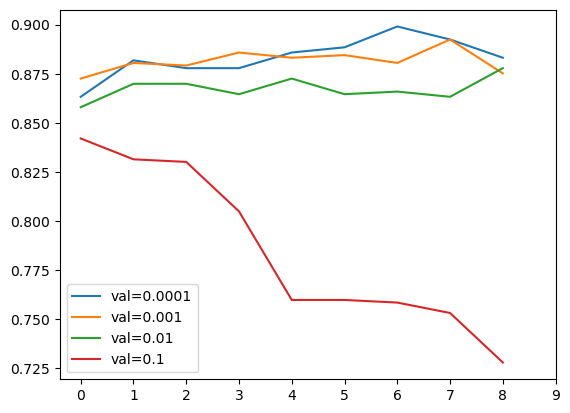

In [44]:
for lr,hist in scores.items():
    plt.plot(hist['val_accuracy'],label=('val=%s'%lr))
plt.xticks(np.arange(10))
plt.legend();

# Adding Layers

In [62]:
def inner_layers(learning_rate=0.0001,size_inner=100):
    
    model = transfer_learning(last_output,base_model,size_inner=size_inner)
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),loss='binary_crossentropy',metrics=['accuracy'])

    return model 

In [73]:
scores = {}
for size in [1000,1500,1800]:
    print(size)
    model = inner_layers(learning_rate,size_inner= size)
    history_fine = model.fit(train_generator,epochs=20,
                             initial_epoch=history.epoch[-1],
                             validation_data=validation_generator)
    scores[size] = history_fine.history

    print()
    print()

1000
Epoch 7/20
71/71 [==============================] - 69s 937ms/step - loss: 0.8408 - accuracy: 0.8160 - val_loss: 0.3552 - val_accuracy: 0.8699
Epoch 8/20
71/71 [==============================] - 61s 860ms/step - loss: 0.4047 - accuracy: 0.8577 - val_loss: 0.2774 - val_accuracy: 0.8765
Epoch 9/20
71/71 [==============================] - 62s 866ms/step - loss: 0.3275 - accuracy: 0.8763 - val_loss: 0.2737 - val_accuracy: 0.8871
Epoch 10/20
71/71 [==============================] - 60s 849ms/step - loss: 0.3078 - accuracy: 0.8763 - val_loss: 0.2697 - val_accuracy: 0.8898
Epoch 11/20
71/71 [==============================] - 60s 838ms/step - loss: 0.2794 - accuracy: 0.8910 - val_loss: 0.2701 - val_accuracy: 0.8938
Epoch 12/20
71/71 [==============================] - 63s 884ms/step - loss: 0.2919 - accuracy: 0.8843 - val_loss: 0.2929 - val_accuracy: 0.8951
Epoch 13/20
71/71 [==============================] - 68s 951ms/step - loss: 0.2839 - accuracy: 0.8812 - val_loss: 0.2734 - val_accurac

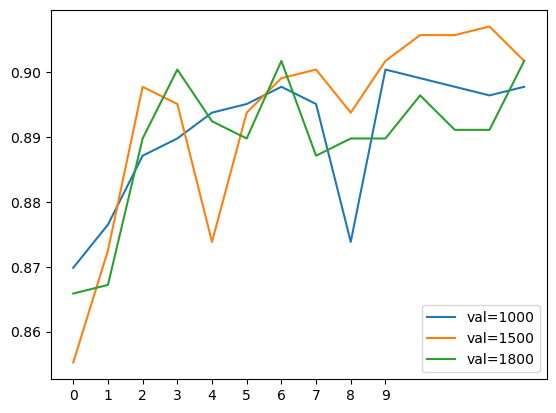

In [74]:
for size,hist in scores.items():
    plt.plot(hist['val_accuracy'],label=('val=%s'%size))
plt.xticks(np.arange(10))
plt.legend();

In [78]:
model.save('C:/Users/SEISANG-G06/Documents/LINN/DATA_CLEANING/BT/model_1')

INFO:tensorflow:Assets written to: C:/Users/SEISANG-G06/Documents/LINN/DATA_CLEANING/BT/model_1\assets


INFO:tensorflow:Assets written to: C:/Users/SEISANG-G06/Documents/LINN/DATA_CLEANING/BT/model_1\assets


In [79]:
# Load the saved model
loaded_model = tf.keras.models.load_model("C:/Users/SEISANG-G06/Documents/LINN/DATA_CLEANING/BT/model_1")

In [82]:
loss, accuracy = loaded_model.evaluate(test_generator)
print('Test accuracy :', accuracy)

24/24 [==============================] - 6s 261ms/step - loss: 0.2475 - accuracy: 0.8991
Test accuracy : 0.8990703821182251
